# Menghasilkan gambar palsu dari aktor dan aktris bioskop menggunakan DCGAN
Jenis data apa yang digunakan dalam proyek ini?

Dalam proyek ini, kami akan menggunakan data gambar, data ini disimpan di kaggle, Anda dapat memeriksanya di [here] (https://www.kaggle.com/datasets/dmitriypushkarev/cineface10). Data gambar tersebut berisi gambar aktor dan aktris film terkenal, ada total 44.765 file dari 1.279 orang sekitar 35 gambar wajah per orang. Lebar dan tinggi gambar adalah 299px.

Masalah apa yang akan kami selesaikan dalam proyek ini?

mengimplementasikan Generative Adversarial Networks (GAN), sebuah arsitektur algoritma jaringan syaraf tiruan tanpa pengawasan di bidang computer vision. GAN didasarkan pada konsep sederhana untuk menghasilkan data yang mirip tapi palsu dari data asli. Baru-baru ini, GAN telah menjadi metode terbaik dalam meniru objek dengan cara yang sangat meyakinkan.

* **Tujuan** - untuk bereksperimen dan menghasilkan gambar palsu dari para aktor dan aktris bioskop.

* **Metodologi** - arsitektur Deep Convolutional Generative Adversarial Network (DCGAN), seperti namanya, kami akan menggunakan lapisan konvolusional dalam jaringan saraf. Metodologi ini adalah dasar di antara berbagai jenis GAN, memahami dan mengimplementasikan arsitektur ini memberikan fondasi yang kuat dalam GAN. PyTorch memiliki [tutorial tentang DCGAN] yang bagus (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html), periksa tutorial ini untuk pembelajaran yang lebih mendalam.


## Importing package

In [1]:
import os
import pathlib
from pathlib import Path
import shutil
from tqdm import tqdm
import numpy as np
import cv2

# package untuk visualiasasi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# package untuk tensorflow
import torch
from torchinfo import summary
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid, save_image

## Dataset

In [2]:
image_data_dir = pathlib.Path('C:/Users/naihw/Kuliah/s2/Semester 2/Komputasi Lanjut/kel 7/CineFace1.0/CineFace1.0')

# cek dataset
print(f'Face directory: {image_data_dir}')
print(f'Number of images in the directory: {len(os.listdir(image_data_dir / "CineFace1.0"))}')

Face directory: C:\Users\naihw\Kuliah\s2\Semester 2\Komputasi Lanjut\kel 7\CineFace1.0\CineFace1.0
Number of images in the directory: 44765



## Praprocessing data
### Creating Dataset and DataLoader



In [3]:
def seed(n: int=42):
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
seed(42)

In [4]:
# input
image_size = 64
batch_size = 128
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
workers = os.cpu_count()

# dataset
dataset = ImageFolder(root=image_data_dir,
                      transform=transforms.Compose([
                          transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=mean, std=std)
                      ]))

# dataloader
seed(42)
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=workers,
                        pin_memory=True)

print('Images in dataset:', len(dataset), 'and Batch in dataloader:', len(dataloader))

Images in dataset: 44765 and Batch in dataloader: 350


In [5]:
# configurasi deevice
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

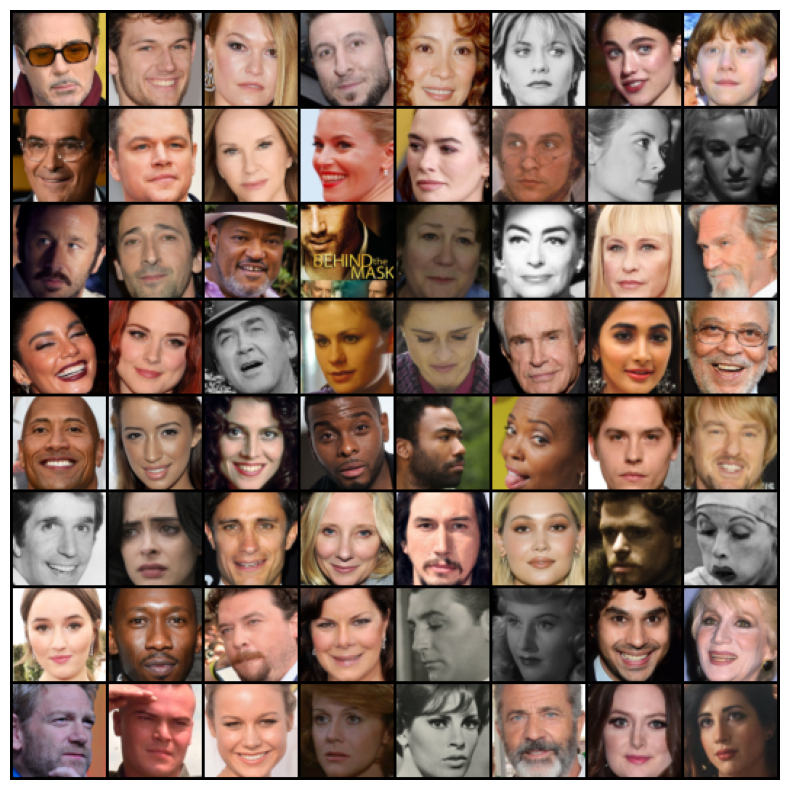

In [6]:
# fungsi untuk plot img ke grid
def plot_grid_images(images, nmax=64, nrow=8):
    plt.figure(figsize=(10, 10))
    plt.imshow(make_grid(images.to(device)[:nmax], nrow=nrow, normalize=True).permute(1, 2, 0).cpu())
    plt.axis(False)
    
def plot_dataloader_images(dataloader, nmax=64, nrow=8):
    images,_ = next(iter(dataloader))
    plot_grid_images(images=images, nmax=nmax, nrow=nrow)
    
plot_dataloader_images(dataloader)

## Modeling


### Discrimination Architecture


In [7]:
# Creating discrimination network architecture
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # in: 3 X 64 X 64
            nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 X 32 X 32
            
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 X 16 X 16
            
            nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 X 8 X 8
            
            nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 X 4 X 4
            
            nn.Conv2d(conv_dim*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 X 1 X 1
            
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

# Creating discriminator model
seed(42)
discriminator_model = Discriminator().to(device)
discriminator_model

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [8]:
# Summary of the discriminator model
summary(model=discriminator_model, 
        input_size=(batch_size, 3, image_size, image_size), 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20, 
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [128, 3, 64, 64]     [128, 1]             --                   True
├─Sequential (main)                      [128, 3, 64, 64]     [128, 1]             --                   True
│    └─Conv2d (0)                        [128, 3, 64, 64]     [128, 64, 32, 32]    3,072                True
│    └─BatchNorm2d (1)                   [128, 64, 32, 32]    [128, 64, 32, 32]    128                  True
│    └─LeakyReLU (2)                     [128, 64, 32, 32]    [128, 64, 32, 32]    --                   --
│    └─Conv2d (3)                        [128, 64, 32, 32]    [128, 128, 16, 16]   131,072              True
│    └─BatchNorm2d (4)                   [128, 128, 16, 16]   [128, 128, 16, 16]   256                  True
│    └─LeakyReLU (5)                     [128, 128, 16, 16]   [128, 128, 16, 16]   --                   --
│    └─Conv2d (6) 

### Generator Architecture

In [9]:
# Creating Generator architecture
class Generator(nn.Module):
    def __init__(self, latent_size: int, conv_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            # in: latent_size X 1 X 1         
            nn.ConvTranspose2d(latent_size, conv_dim*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dim*8),
            nn.ReLU(inplace=True),
            # out: 512 X 4 X 4
            
            nn.ConvTranspose2d(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.ReLU(inplace=True),
            # out: 256 X 8 X 8
            
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.ReLU(inplace=True),
            # out: 128 X 16 X 16
            
            nn.ConvTranspose2d(conv_dim*2, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(inplace=True),
            # out: 64 X 32 X 32
            
            nn.ConvTranspose2d(conv_dim, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 X 64 X 64
        )
    def forward(self, input):
        return self.main(input)

# Creating the Generator model
seed(42)
# Using latent size of 128
latent_size = 128
generator_model = Generator(latent_size).to(device)
generator_model

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [10]:
# Summary of the generator model
summary(model=generator_model, 
        input_size=(batch_size, latent_size, 1, 1), 
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        col_width=20, 
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [128, 128, 1, 1]     [128, 3, 64, 64]     --                   True
├─Sequential (main)                      [128, 128, 1, 1]     [128, 3, 64, 64]     --                   True
│    └─ConvTranspose2d (0)               [128, 128, 1, 1]     [128, 512, 4, 4]     1,048,576            True
│    └─BatchNorm2d (1)                   [128, 512, 4, 4]     [128, 512, 4, 4]     1,024                True
│    └─ReLU (2)                          [128, 512, 4, 4]     [128, 512, 4, 4]     --                   --
│    └─ConvTranspose2d (3)               [128, 512, 4, 4]     [128, 256, 8, 8]     2,097,152            True
│    └─BatchNorm2d (4)                   [128, 256, 8, 8]     [128, 256, 8, 8]     512                  True
│    └─ReLU (5)                          [128, 256, 8, 8]     [128, 256, 8, 8]     --                   --
│    └─ConvTranspo

torch.Size([128, 3, 64, 64])


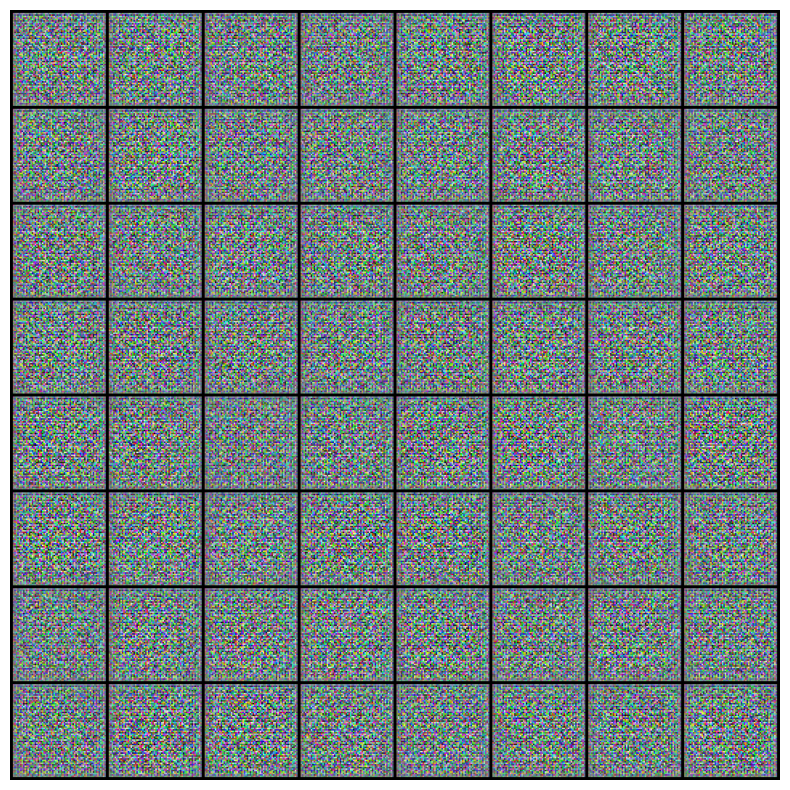

In [11]:
# Apply random tensor of latent size to the generator model
seed(42)
x = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_image = generator_model(x)
print(fake_image.shape)
plot_grid_images(images=fake_image)

### Discriminator Training


In [12]:
# Creating a function for training the discriminator model
def train_discriminator(real_images, batch_size, latent_size, loss_fn, dis_opt):
    # zeroing gradients
    dis_opt.zero_grad()
    
    # Passing real images into the discriminator model
    real_preds = discriminator_model(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss_fn(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generating Fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_model(latent)
    
    # Passing fake images into the discriminator model
    fake_preds = discriminator_model(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = loss_fn(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update the discriminator weights using the optimizer
    loss = real_loss + fake_loss
    loss.backward()
    dis_opt.step()
    return loss.item(), real_score, fake_score

### Generator Training


In [13]:
# Creating a function for training the generator model
def train_generator(batch_size, latent_size, loss_fn, gen_opt):
    # Zeroing gradients
    gen_opt.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator_model(latent)
    
    # Passing the images to discriminator model
    preds = discriminator_model(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = loss_fn(preds, targets)
    
    # Update the generator weights unsing the optimizer
    loss.backward()
    gen_opt.step()
    return loss.item()

In [14]:
# Creating a folder to contain all the images generated by the Generator
generator_img_dir = Path('generated')
if generator_img_dir.exists():
    print('[INFO] Generator image directory already exist.')
else:
    generator_img_dir.mkdir(parents=True, exist_ok=True)

[INFO] Generator image directory already exist.


In [15]:
# Creating a helper function that saves output of generated images
def save_generated_samples(index, latent_tensor, show=True, nrow=8, nmax=64):
    fake_images = generator_model(latent_tensor)
    fake_file_name = f'generated_images_{index:0=4d}.jpg'
    save_image(tensor=fake_images[:nmax], fp=generator_img_dir / fake_file_name, normalize=True, nrow=nrow)
    print(f'Saving {fake_file_name}\n')
    if show:
        plt.figure(figsize=(8, 8))
        plot_grid_images(images=fake_images, nrow=nrow, nmax=nmax)

Saving generated_images_0000.jpg



<Figure size 800x800 with 0 Axes>

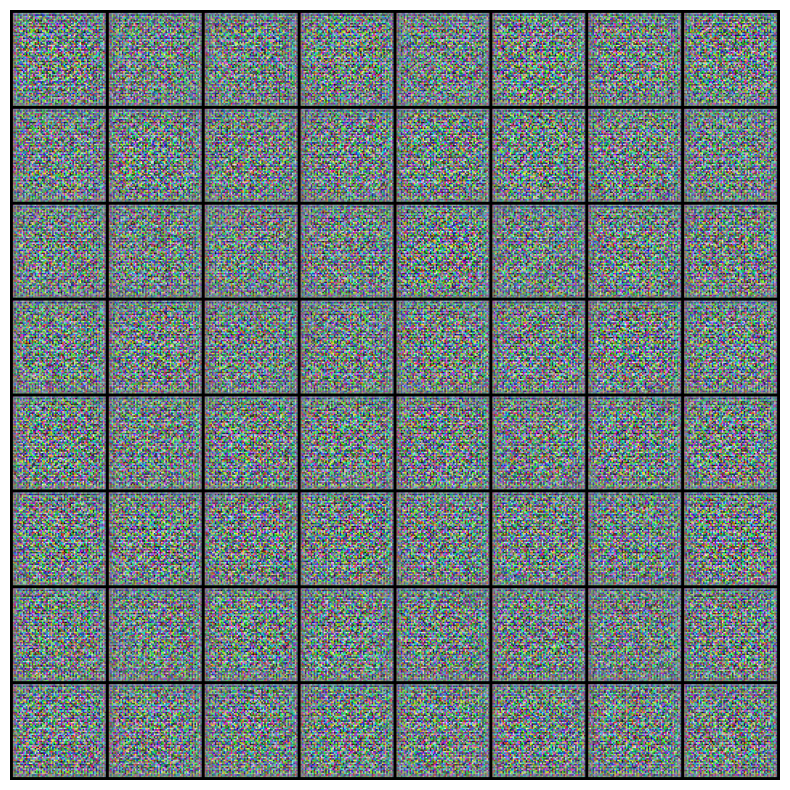

In [16]:
# Testing the helper function to save generated samples
random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
save_generated_samples(0, random_latent)

### Training loop


In [17]:
# Creating a fit function for training the model
def fit(epochs, lr, beta1, device, batch_size, latent_size, start_idx=1):
    # Clearing GPU cache
    torch.cuda.empty_cache()
    
    # list for losses and scores
    gen_losses = []
    dis_losses = []
    real_scores = []
    fake_scores = []
    
    # Creating optimizer and loss
    loss_fn = nn.BCELoss()
    dis_opt = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, 0.999))
    gen_opt = torch.optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Starting the model training
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator model
            dis_loss, real_score, fake_score = train_discriminator(real_images=real_images, 
                                                                   batch_size=batch_size, 
                                                                   latent_size=latent_size, 
                                                                   loss_fn=loss_fn, 
                                                                   dis_opt=dis_opt)
            # train generator model
            gen_loss = train_generator(batch_size=batch_size, 
                                       latent_size=latent_size, 
                                       loss_fn=loss_fn, 
                                       gen_opt=gen_opt)
        
        # Record losses and scores
        gen_losses.append(gen_loss)
        dis_losses.append(dis_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Display losses and scores for every epoch
        print(f'Epoch: [{epoch+1}/{epochs}] | dis_loss: {dis_loss:.4f} | gen_loss: {gen_loss:.4f} | real_score: {real_score:.4f} | fake_score: {fake_score:.4f}')
        
        # Save generated image
        random_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        save_generated_samples(index=epoch+start_idx, latent_tensor=random_latent, show=False)
    return dis_losses, gen_losses, real_scores, fake_scores

We are now all set to train the model.

In [ ]:
# Inputs for training model
epochs = 50
lr = 0.0002
beta1 = 0.5
history = fit(epochs=epochs, 
              lr=lr, 
              beta1=beta1, 
              device=device, 
              batch_size=batch_size,
              latent_size=latent_size)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [17:01<00:00,  2.92s/it]


Epoch: [1/50] | dis_loss: 0.2321 | gen_loss: 3.8993 | real_score: 0.8390 | fake_score: 0.0350
Saving generated_images_0001.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [13:55<00:00,  2.39s/it]


Epoch: [2/50] | dis_loss: 0.3835 | gen_loss: 3.7449 | real_score: 0.9690 | fake_score: 0.2628
Saving generated_images_0002.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:50<00:00,  1.86s/it]


Epoch: [3/50] | dis_loss: 0.8075 | gen_loss: 1.9558 | real_score: 0.5984 | fake_score: 0.1539
Saving generated_images_0003.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [11:10<00:00,  1.91s/it]


Epoch: [4/50] | dis_loss: 0.4359 | gen_loss: 4.0002 | real_score: 0.8766 | fake_score: 0.2235
Saving generated_images_0004.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:44<00:00,  1.84s/it]


Epoch: [5/50] | dis_loss: 0.6800 | gen_loss: 2.0168 | real_score: 0.6052 | fake_score: 0.0479
Saving generated_images_0005.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:43<00:00,  1.84s/it]


Epoch: [6/50] | dis_loss: 0.3868 | gen_loss: 3.4196 | real_score: 0.7940 | fake_score: 0.1183
Saving generated_images_0006.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:39<00:00,  1.83s/it]


Epoch: [7/50] | dis_loss: 0.4539 | gen_loss: 5.0220 | real_score: 0.8933 | fake_score: 0.2548
Saving generated_images_0007.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:40<00:00,  1.83s/it]


Epoch: [8/50] | dis_loss: 1.1591 | gen_loss: 0.9684 | real_score: 0.4103 | fake_score: 0.0123
Saving generated_images_0008.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:47<00:00,  1.85s/it]


Epoch: [9/50] | dis_loss: 0.9433 | gen_loss: 6.0063 | real_score: 0.9751 | fake_score: 0.5374
Saving generated_images_0009.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [10:47<00:00,  1.85s/it]


Epoch: [10/50] | dis_loss: 1.7093 | gen_loss: 7.2537 | real_score: 0.9938 | fake_score: 0.7471
Saving generated_images_0010.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [15:43<00:00,  2.70s/it]


Epoch: [11/50] | dis_loss: 0.2571 | gen_loss: 4.3051 | real_score: 0.9673 | fake_score: 0.1860
Saving generated_images_0011.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [18:30<00:00,  3.17s/it]


Epoch: [12/50] | dis_loss: 0.3647 | gen_loss: 3.9948 | real_score: 0.9629 | fake_score: 0.2478
Saving generated_images_0012.jpg



100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [17:35<00:00,  3.02s/it]


Epoch: [13/50] | dis_loss: 0.2833 | gen_loss: 3.3656 | real_score: 0.8377 | fake_score: 0.0729
Saving generated_images_0013.jpg



 69%|███████████████████████████████████████████████████████▎                        | 242/350 [33:10<03:07,  1.73s/it]

## Result


### Losses and Scores Plot

In [ ]:
# Storing the training data
dis_losses, gen_losses, real_scores, fake_scores = history

In [ ]:
# ploting the loss and score curves
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(dis_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title('Discrimnator and Generator Loss Durning Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(real_scores, label='Real score')
plt.plot(fake_scores, label='Fake Score')
plt.title('Discrimnator Scores Durning Training')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend();

### Sample Visualization

In [ ]:
# Collecting generated images in a list
sample_img_list = [os.path.join(generator_img_dir, f) for f in os.listdir(generator_img_dir) if 'generated' in f]
sample_img_list.sort()

# Image visualiztion at every 10 epochs interval
img_index = [1, 10, 20, 30, 40, 50]
plt.figure(figsize=(18, 25))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(plt.imread(sample_img_list[img_index[i]]))
    plt.title(sample_img_list[img_index[i]])
    plt.axis(False)

In [ ]:
# Visualizing the sample data from directory 'generated'
matplotlib.rcParams['animation.embed_limit'] = 2**128 
fig = plt.figure(figsize=(8, 8))
plt.axis(False)
sample_img = [[plt.imshow(plt.imread(i), animated=True)] for i in sample_img_list]
sample_animation = animation.ArtistAnimation(fig, sample_img, interval=500, repeat_delay=1000, blit=True)
HTML(sample_animation.to_jshtml())

## Conclusion

In this project, we learn to produce face images using the Deep Convolutional General Adversarial Networks, we also build two specific neural network architecture - Discriminator and Generator. 

This two core architectures are then trained onto each other where one supports and boost the other models performance. While we have only trained the model for 50 epochs in our first experiment, the model are already capable to produce face images with features like hair, nose, eyes, eyebrows, ears and skin tone. 

Still, the model needs improvement where we can also see some limitations like face shape and skin color. We can imporve the model by running some more experiments like increasing the epochs, changing the learning rate and once the model has started to almost create perfect images we can work to increase the image resolution.